In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bqplot.pyplot as bqplt
import matplotlib as mpl
#mpl.style.use('default')
#These are some matplot lib configurations that I like to use. 
#mpl.rc("text", usetex=True) #if tou have Latex set this to true and matplotlib will render labels in latex
mpl.rc("font", family = "serif") #Serif font in matplotlib
mpl.rc("figure",figsize=(9,6)) #Increase default figure size
%config InlineBackend.figure_format = 'retina' #If you have a high res display, render the plots more nicely
mpl.style.use('dark_background') #Use a dark background for matplotlib figures if youre using dark theme
plt.rcParams.update({"figure.facecolor": "111111",
                     "savefig.facecolor": "212121"})

In [2]:
import geopandas as gpd
import pandas as pd

In [3]:
from ipywidgets import Dropdown, jslink, SelectionSlider, Play, HBox, VBox
from bqplot import Lines, Figure, LinearScale, DateScale, Axis
from ipyleaflet import Map, GeoData, WidgetControl, basemaps, LayerGroup, Choropleth, GeoJSON, Heatmap
from branca.colormap import linear
import json

In [4]:
from ipywidgets import Text, HTML
from ipyleaflet import WidgetControl

# The spread of COVID 19 in the Continental US

Made by John Russell.

- Last update was 4/29/20 though much of the data is older. I'll try to update soon. 

First, we can see how the virus spread in the US. This data is from [John Hopkins](https://github.com/govex/COVID-19/tree/master/data_tables/JHU_USCountymap) and represents the number of confirmed cases in each county in the US. If you zoom in enough to see individual data points they are located at the geographic center of each county. 

The colorbar is only semi-quantitative but red is more cases and lighter yellow is fewer. You can really see the spread out of the major urban areas across the country but especially New York.

In [5]:
jhu_data = gpd.read_file('data/heatmap_us_counties.shp')
jhu_data.rename(columns={col:pd.to_datetime(col) for col in jhu_data.columns[2:-1]}, inplace=True)
dates = jhu_data.columns[2:-1]

In [6]:
date_options = list(zip(pd.to_datetime(dates).strftime('%b %d %Y'),dates))
slider = SelectionSlider(description='Date:', options=date_options)

def update_heatmap(change):
    heatmap.locations = np.array([jhu_data.geometry.y.values,jhu_data.geometry.x.values, jhu_data[slider.value].values]).T.tolist()

slider.observe(update_heatmap, 'value')

play = Play( interval=250, value=70, min=0, max=len(dates)-1, step=1, disabled=False)
slider.layout.width='400px'
jslink((play, 'value'), (slider, 'index'))
hbox = HBox([play, slider])

In [7]:
m = Map(basemap=basemaps.CartoDB.DarkMatter, center=[38,-93], zoom=4)
date = pd.to_datetime('4/6/20')
locations = np.array([jhu_data.geometry.y.values,jhu_data.geometry.x.values, jhu_data[date].values]).T.tolist()
heatmap = Heatmap(locations=locations, radius = 30,blur = 45, max = 2 )
heatmap.gradient = {0: 'yellow', 0.5 :'orange', 1.: 'red'}
m.add_layer(heatmap)
m.layout.height = '600px'
#print(date)
VBox([m,hbox])

In [8]:
###### BREAK #######

In [9]:
def geojson_madness(jfname, idkey):
    with open(jfname,'r') as f:
        geojson = json.load(f)
    for f in geojson['features']:
        f['id'] = f['properties'][idkey]
    return geojson

In [10]:
json_covid_states = geojson_madness('data/state_covid.geojson','STUSPS')

In [11]:
minimal = pd.read_csv('data/state_covid_traces.csv')

In [12]:
minimal.dates = minimal.dates.apply(lambda x: pd.to_datetime(x.strip('[]').split()))
for col in ['td_mean', 'td_upper', 'td_lower']:
    minimal[col] = minimal[col].apply(lambda x: np.array(x.strip('[]').split(','),dtype=np.double))

In [13]:
geoj = GeoJSON(data = json_covid_states,style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.0},
                   hover_style={'fillColor': 'black' , 'fillOpacity': 0.1},
                   name = 'States')

In [14]:
td_to_come_choro = Choropleth(
    geo_data=json_covid_states,
    choro_data=dict(zip(minimal['STUSPS'].values, minimal['td_tocome'].values)),
    colormap=linear.YlGnBu_04,
    border_color='black',
    style={'fillOpacity': 0.8, 'dashArray': '5, 5'})

td_per10k_now_choro = Choropleth(
    geo_data=json_covid_states,
    choro_data=dict(zip(minimal['STUSPS'].values, minimal['td_per10k_now'].values)),
    colormap=linear.YlGnBu_04,
    border_color='black',
    style={'fillOpacity': 0.8, 'dashArray': '5, 5'})

choro_layers = [td_per10k_now_choro,td_to_come_choro]
layer_group = LayerGroup(layers=(td_per10k_now_choro,geoj))

dropdown = Dropdown(options=['Death Rate per 10k People as of 4/12', 'Fraction of deaths yet to come'])

def change_layer(change):
    print(dropdown.index)
    layer_group.clear_layers()
    layer_group.add_layer(choro_layers[dropdown.index])
    layer_group.add_layer(geoj)
    
dropdown.observe(change_layer,'value')
layer_chooser = WidgetControl(widget = dropdown, position='bottomleft')

In [15]:
x_scale = LinearScale()
state_name = 'Massachusetts'
init = minimal.loc[minimal['NAME']==state_name]
dates = init['dates'].values[0]
date_scale = DateScale(min=dates[0], max=dates[-1])

mean = Lines(x=dates, y=init['td_mean'].values[0], scales={'x': date_scale, 'y': x_scale})
upper = Lines(x=dates, y=init['td_upper'].values[0], line_style='dashed', scales={'x': date_scale, 'y': x_scale})
lower = Lines(x=dates, y=init['td_lower'].values[0],  line_style='dashed', scales={'x': date_scale, 'y': x_scale})
ax_x = Axis(label='Time', scale=date_scale, num_ticks=10)
ax_y = Axis(label="Total Deaths", scale=x_scale, orientation='vertical', side='left')

figure = Figure(axes=[ax_x, ax_y], title=state_name+' Projections', marks=[mean, upper, lower], animation_duration=500,
                layout={'max_height': '500px', 'max_width': '800px'})

In [16]:
html = HTML('''Hover over a state''')
html.layout.margin = '0px 20px 20px 20px'
stat_viewer = WidgetControl(widget=html, position='topright')
def update_html(feature, **kwargs):
    html.value = '''
        <h4>State Covid19 Deaths</h4>
        <h4><b>{}</b></h4>
        <h4>{} as of 4/12/20</h4>
        <h4>{} projected on 8/1/20</h4>
        <h4>{} Fraction yet to come</h4>
    '''.format(feature['properties']['NAME'], 
               np.round(feature['properties']['td_per10k_now'],decimals=4), 
               np.round(feature['properties']['td_per10k_proj'],decimals=4),
               np.round(feature['properties']['td_tocome'],decimals=4)
              )
    
def update_plot(feature, **kwargs):
    #print('here')
    global state_name
    state_name = feature['properties']['NAME']
    update_figure(state_name)

geoj.on_hover(update_html)
geoj.on_click(update_plot)

In [17]:
def update_figure(state):
    #print('here')
    mean.y = minimal.loc[minimal['NAME'] == state]['td_mean'].values[0]
    upper.y = minimal.loc[minimal['NAME'] == state]['td_upper'].values[0]
    lower.y = minimal.loc[minimal['NAME'] == state]['td_lower'].values[0]
    #ax_y.label = data_name.capitalize()
    figure.title = state+ ' Projections'

# The Deadliness of COVID19 in the Continental US

You can mouseover the states to see their current rates (updated 4/12/20) and the projections from the IHME for August 1, 2020. Rates are given in deaths per $10^4$ people. Unfortuntely I havent been able to display a colorbar yet but blue corresponds to higher values and yellow to lower ones. Wyoming currently has 0 so and New York has the most for reference.

You can also change how the states are colored using the dropdown menu in the bottom left. Currently the only options are what I previously described or to color by the fraction of predicted deaths that have yet to come. For exmaple, if c a state has experienced 100 deaths and 

If you click on a state, its IHME data will appear on the plot below. The solid line is the model average and the dashed lines indiciate the upper and lower bounds from the model.

In [18]:
m = Map(basemap=basemaps.CartoDB.DarkMatter, center=[38,-90], zoom=4)
m.add_layer(layer_group)
m.add_control(stat_viewer)
m.add_control(layer_chooser)

In [19]:
m

Map(center=[38, -90], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [20]:
figure

Figure(animation_duration=500, axes=[Axis(label='Time', num_ticks=10, scale=DateScale(max=Timestamp('2020-08-0…

It took me a while to learn how to make this all interactive and available but I will try to add any other cool maps as I make them. Before I started making interactive ones I took a look at the correlation of COVID deaths and political affiliation. Turns out that the , fraction of projected deaths yet to come map looks a lot like the results of the 2016 election. Ill leave you with a couple scatter plots to show what I mean.

In [21]:
votes = pd.read_csv('data/state_2016_pres.csv')
votes = votes.loc[votes['year']==2016]
#votes = votes.loc[votes['party'].isin(['democrat', 'reublican'])]
votes = votes.loc[~votes['writein']]
votes = votes.rename(columns={'state_fips':'GEOID'})
votes = votes.loc[votes['GEOID'].isin(minimal['GEOID'].unique())]
dem = votes.loc[votes['party']=='democrat']
rep = votes.loc[votes['party']=='republican']
dem = dem[['state', 'GEOID', 'candidatevotes', 'totalvotes']]
dem = dem.rename(columns={'candidatevotes':'demvotes'})
rep = rep.rename(columns={'candidatevotes':'repvotes'})
split_votes = dem.merge(rep[['state','repvotes']], on='state')

In [22]:
split_votes = split_votes.assign(dfrac=lambda df: df['demvotes']/df['totalvotes'])
split_votes = split_votes.assign(rfrac=lambda df: df['repvotes']/df['totalvotes'])

In [23]:
minimal = minimal.merge(split_votes[['GEOID', 'demvotes', 'totalvotes', 'repvotes', 'dfrac',
       'rfrac']], on='GEOID')

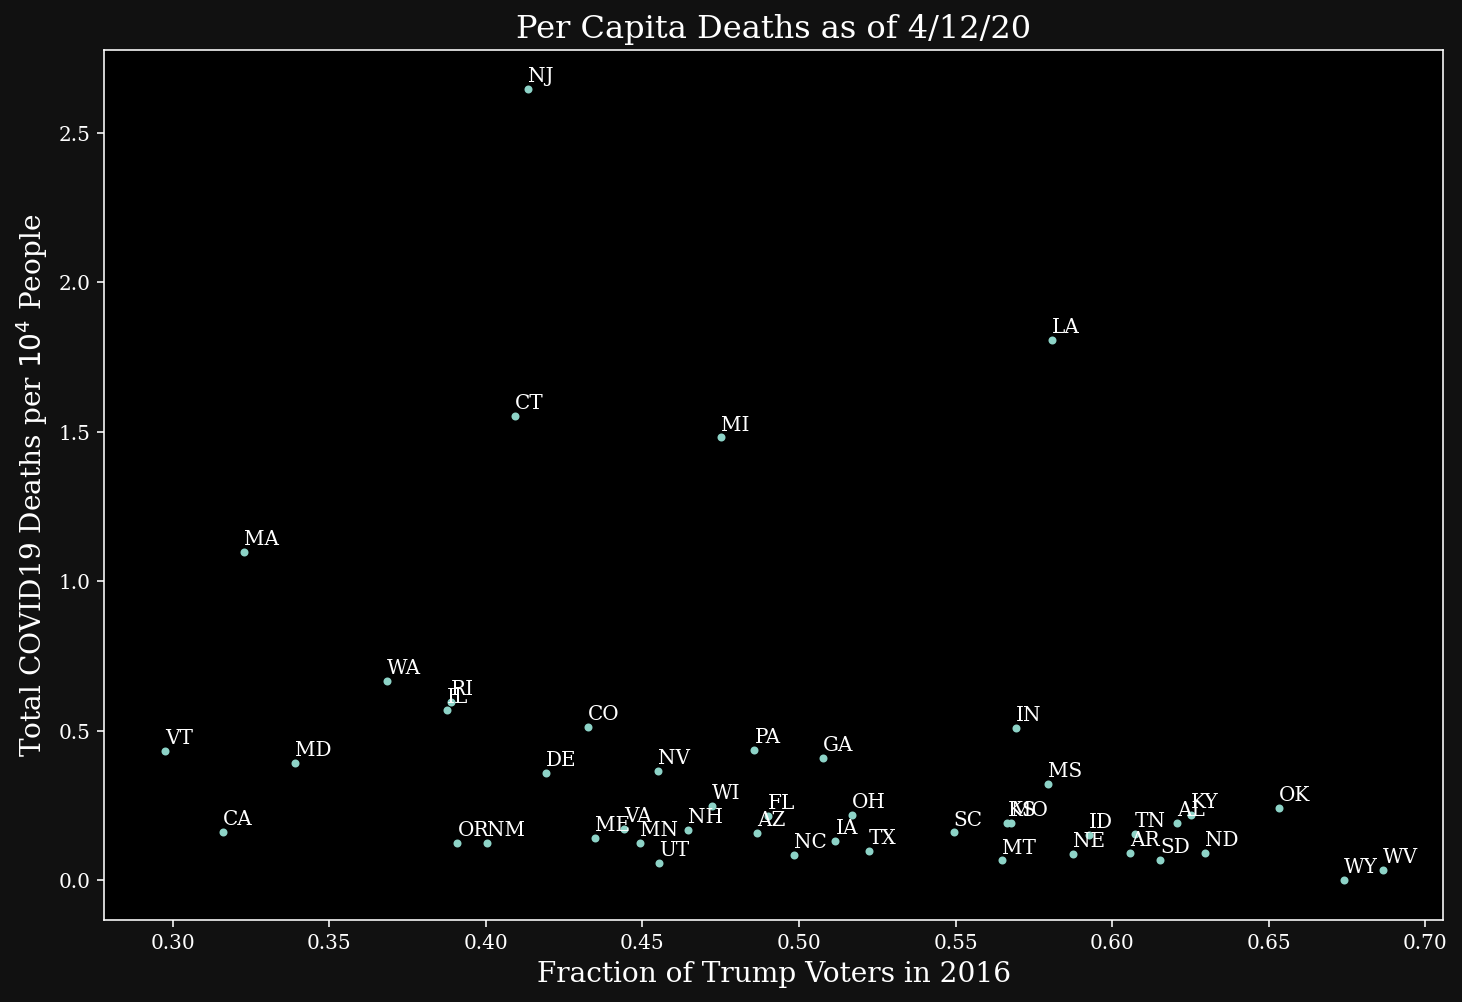

In [24]:
tmp = minimal.loc[~minimal['STUSPS'].isin(['NY','DC'])]
tmp = tmp.reset_index()
plt.figure(figsize=(12,8))
plt.scatter(tmp['rfrac'], tmp['td_per10k_now'], marker='.')
ax = plt.gca()
for i,t in enumerate(tmp['STUSPS']):
    ax.annotate(t, (tmp['rfrac'][i], tmp['td_per10k_now'][i]+0.025), fontsize=10)
ax.set_ylabel(r'Total COVID19 Deaths per $10^4$ People',fontsize=14)
ax.set_xlabel(r'Fraction of Trump Voters in 2016',fontsize=14)
plt.title("Per Capita Deaths as of 4/12/20",fontsize=16)
#plt.savefig('covid_vs_rfrac.png',dpi=500)
plt.show()

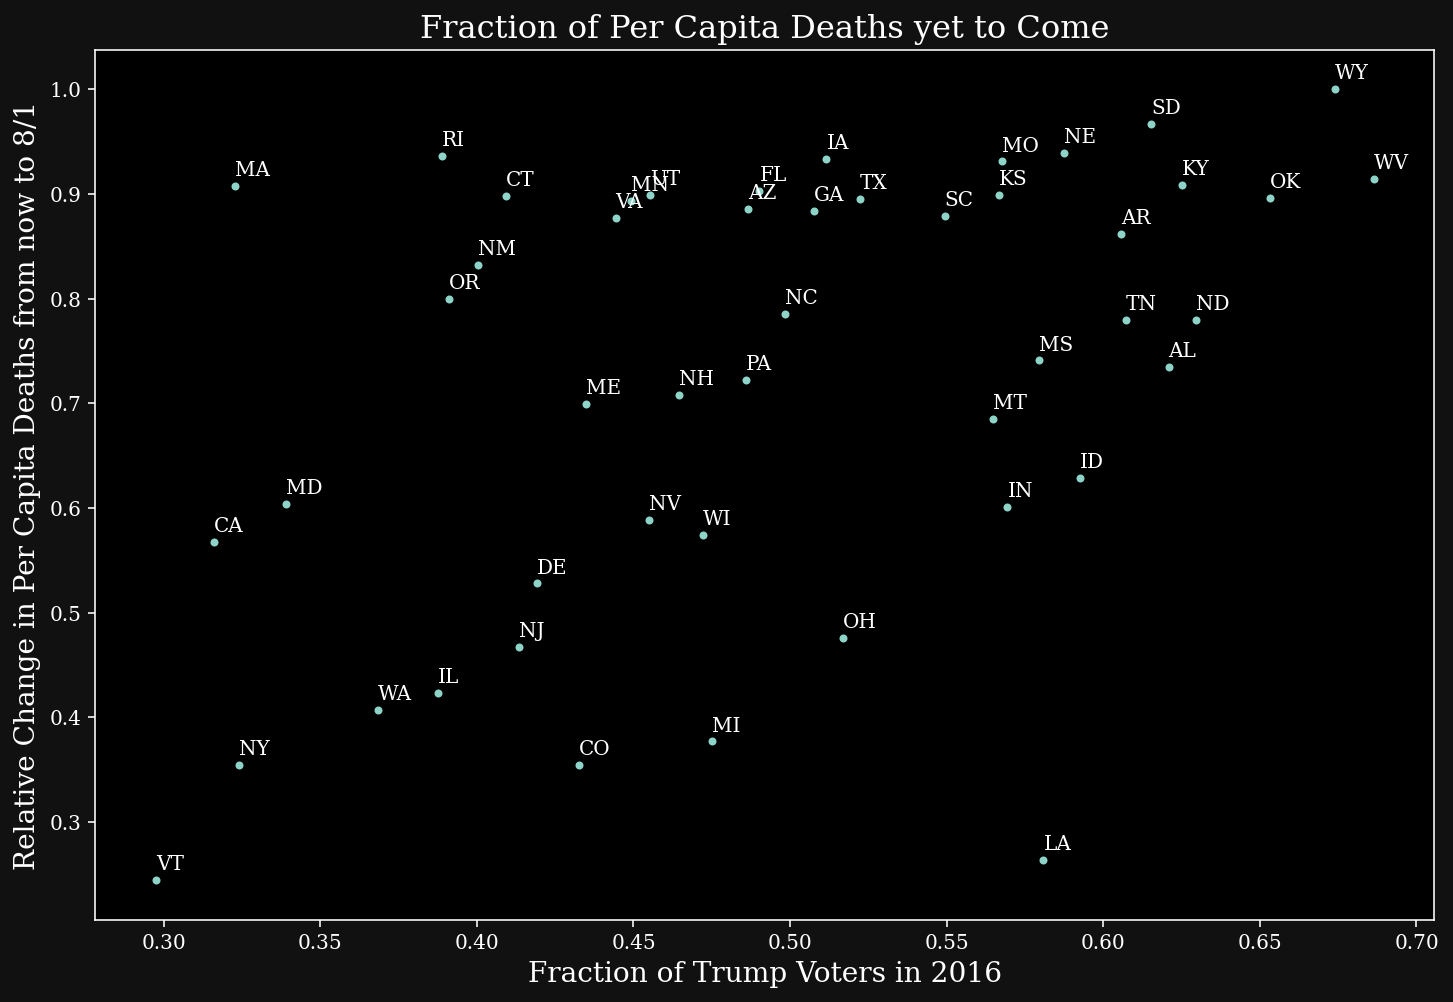

In [25]:
tmp = minimal.loc[~minimal['STUSPS'].isin(['DC'])]
tmp = tmp.reset_index()
plt.figure(figsize=(12,8))
plt.scatter(tmp['rfrac'], tmp['td_tocome'], marker='.')
ax = plt.gca()
for i,t in enumerate(tmp['STUSPS']):
    ax.annotate(t, (tmp['rfrac'][i], tmp['td_tocome'][i]+0.01), fontsize=10)
ax.set_xlabel(r'Fraction of Trump Voters in 2016',fontsize=14)
ax.set_ylabel(r'Relative Change in Per Capita Deaths from now to 8/1',fontsize=14)
plt.title("Fraction of Per Capita Deaths yet to Come",fontsize=16)
#plt.savefig('delta_pcd_vs_rfrac.png',dpi=500)
plt.show()

If you want to see the jupyter notebook that generated this its available [on my github](https://github.com/jrussell25/cartography/blob/master/covid_map.ipynb). If you have any comments or really want to see something else let me know or open an issue. 